### Import Data

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('dark_background')


eeg_fpath = '/Volumes/Transfer/data/eeg/EEG Daten'
    

subjects = ['ls02ICA',
            'lw03ICA',
            'jb04ICA',
            'mn05ICA',
            're06ICA',
            'ev07ICA',
            'nr08ICA',
            'sw13ICA',
            'lf14ICA',
            'lk15ICA',
            'sp16ICA',
            'hr17ICA',
            'sd19ICA',
            'nro20ICA',
            'lb21ICA',
            'jg22ICA',
            'al23ICA',
            'fs25ICA',
            'am26ICA',
            'lsc27ICA',
            'rg28ICA']

conditions = ['NoPress',
              # 'NoSound',
              'Sound']

def import_eeg(fpath:str,subject_ids:list[str],conditions:list[str]) -> dict:
    '''Load EEG and meta data from .mat files
    
    Params:
    fpath: Path to EEG directory
    subject_ids: Subject pseudonyms as used in file names
    conditions: Condition descriptors as used in file names

    Returns: Data grouped by condition and subjects
    '''
    data = {}
    for condition in conditions:
        tmp = {}
        for subject in subject_ids:
            m = sp.io.loadmat(os.path.join(fpath,subject+condition),simplify_cells=True)
            events = np.array([[event['latency'],event['type']] for event in m['EEG']['event']],dtype=object)
            tmp[subject] = {'intervals':get_intervals(events,condition), # samples
                            'locations':[location['labels'] for location in m['EEG']['chanlocs']],
                            'eeg':np.array(m['EEG']['data'],dtype=float), # mV ?
                            'sampling_rate':m['EEG']['srate'], # Hz
                            'times':np.array(m['EEG']['times'],dtype=int)} # ms
        data[condition] = tmp
    return data


def get_eeg(data:dict[dict[dict]],condition:str|int,subject:str|int):
    '''Extract condition and subject specific data fields
    
    Params:
    data: Database containing all conditions and subjects
    condition: Condition specifier or index
    subject: Subject pseudonym or index
    
    Returns: Event times, electrode locations, EEG data, sampling rate, times'''
    
    conditions = list(data.keys())
    subjects = list(data[conditions[0]].keys())
    if isinstance(condition,int):
        condition = conditions[condition]
    if isinstance(subject,int):
        subject = subjects[subject]

    return [data[condition][subject][key] for key in data[condition][subject].keys()]


def get_intervals(events:list,condition:str) -> list[float,float]|list[list[float,float]]:
    '''Extract primary stimulus intervals for SOAs
    
    Params:
    events: EEG events containing latency and stimulus ID
    condition: Experimental condition ID ('NoPress','Sound')
    
    Returns: Start and end points of intervals grouped by SOA'''

    soa_ids = ['S  1',
               'S  2',
               'S  3',
               'S  4']
    intervals = []

    if condition == 'NoPress':
        soa_idc = np.array(np.where(events[:,1] == soa_ids[0])).squeeze()
        intervals.append(np.array([events[soa_idc,0],events[soa_idc+1,0]],dtype=int).T)
        return intervals

    elif condition == 'Sound':
        for soa in soa_ids:
            soa_idc = np.array(np.where(events[:,1] == soa)).squeeze()
            soa_intervals = np.array([events[soa_idc,0],events[soa_idc+1,0]],dtype=int).T
            intervals.append(soa_intervals)
        return intervals
    elif condition == 'NoSound':
        return []
    else:
        raise ValueError(f'"{condition}" is not a valid condition')

data = import_eeg(eeg_fpath,subjects,conditions)

### Check raw data for single subject & condition

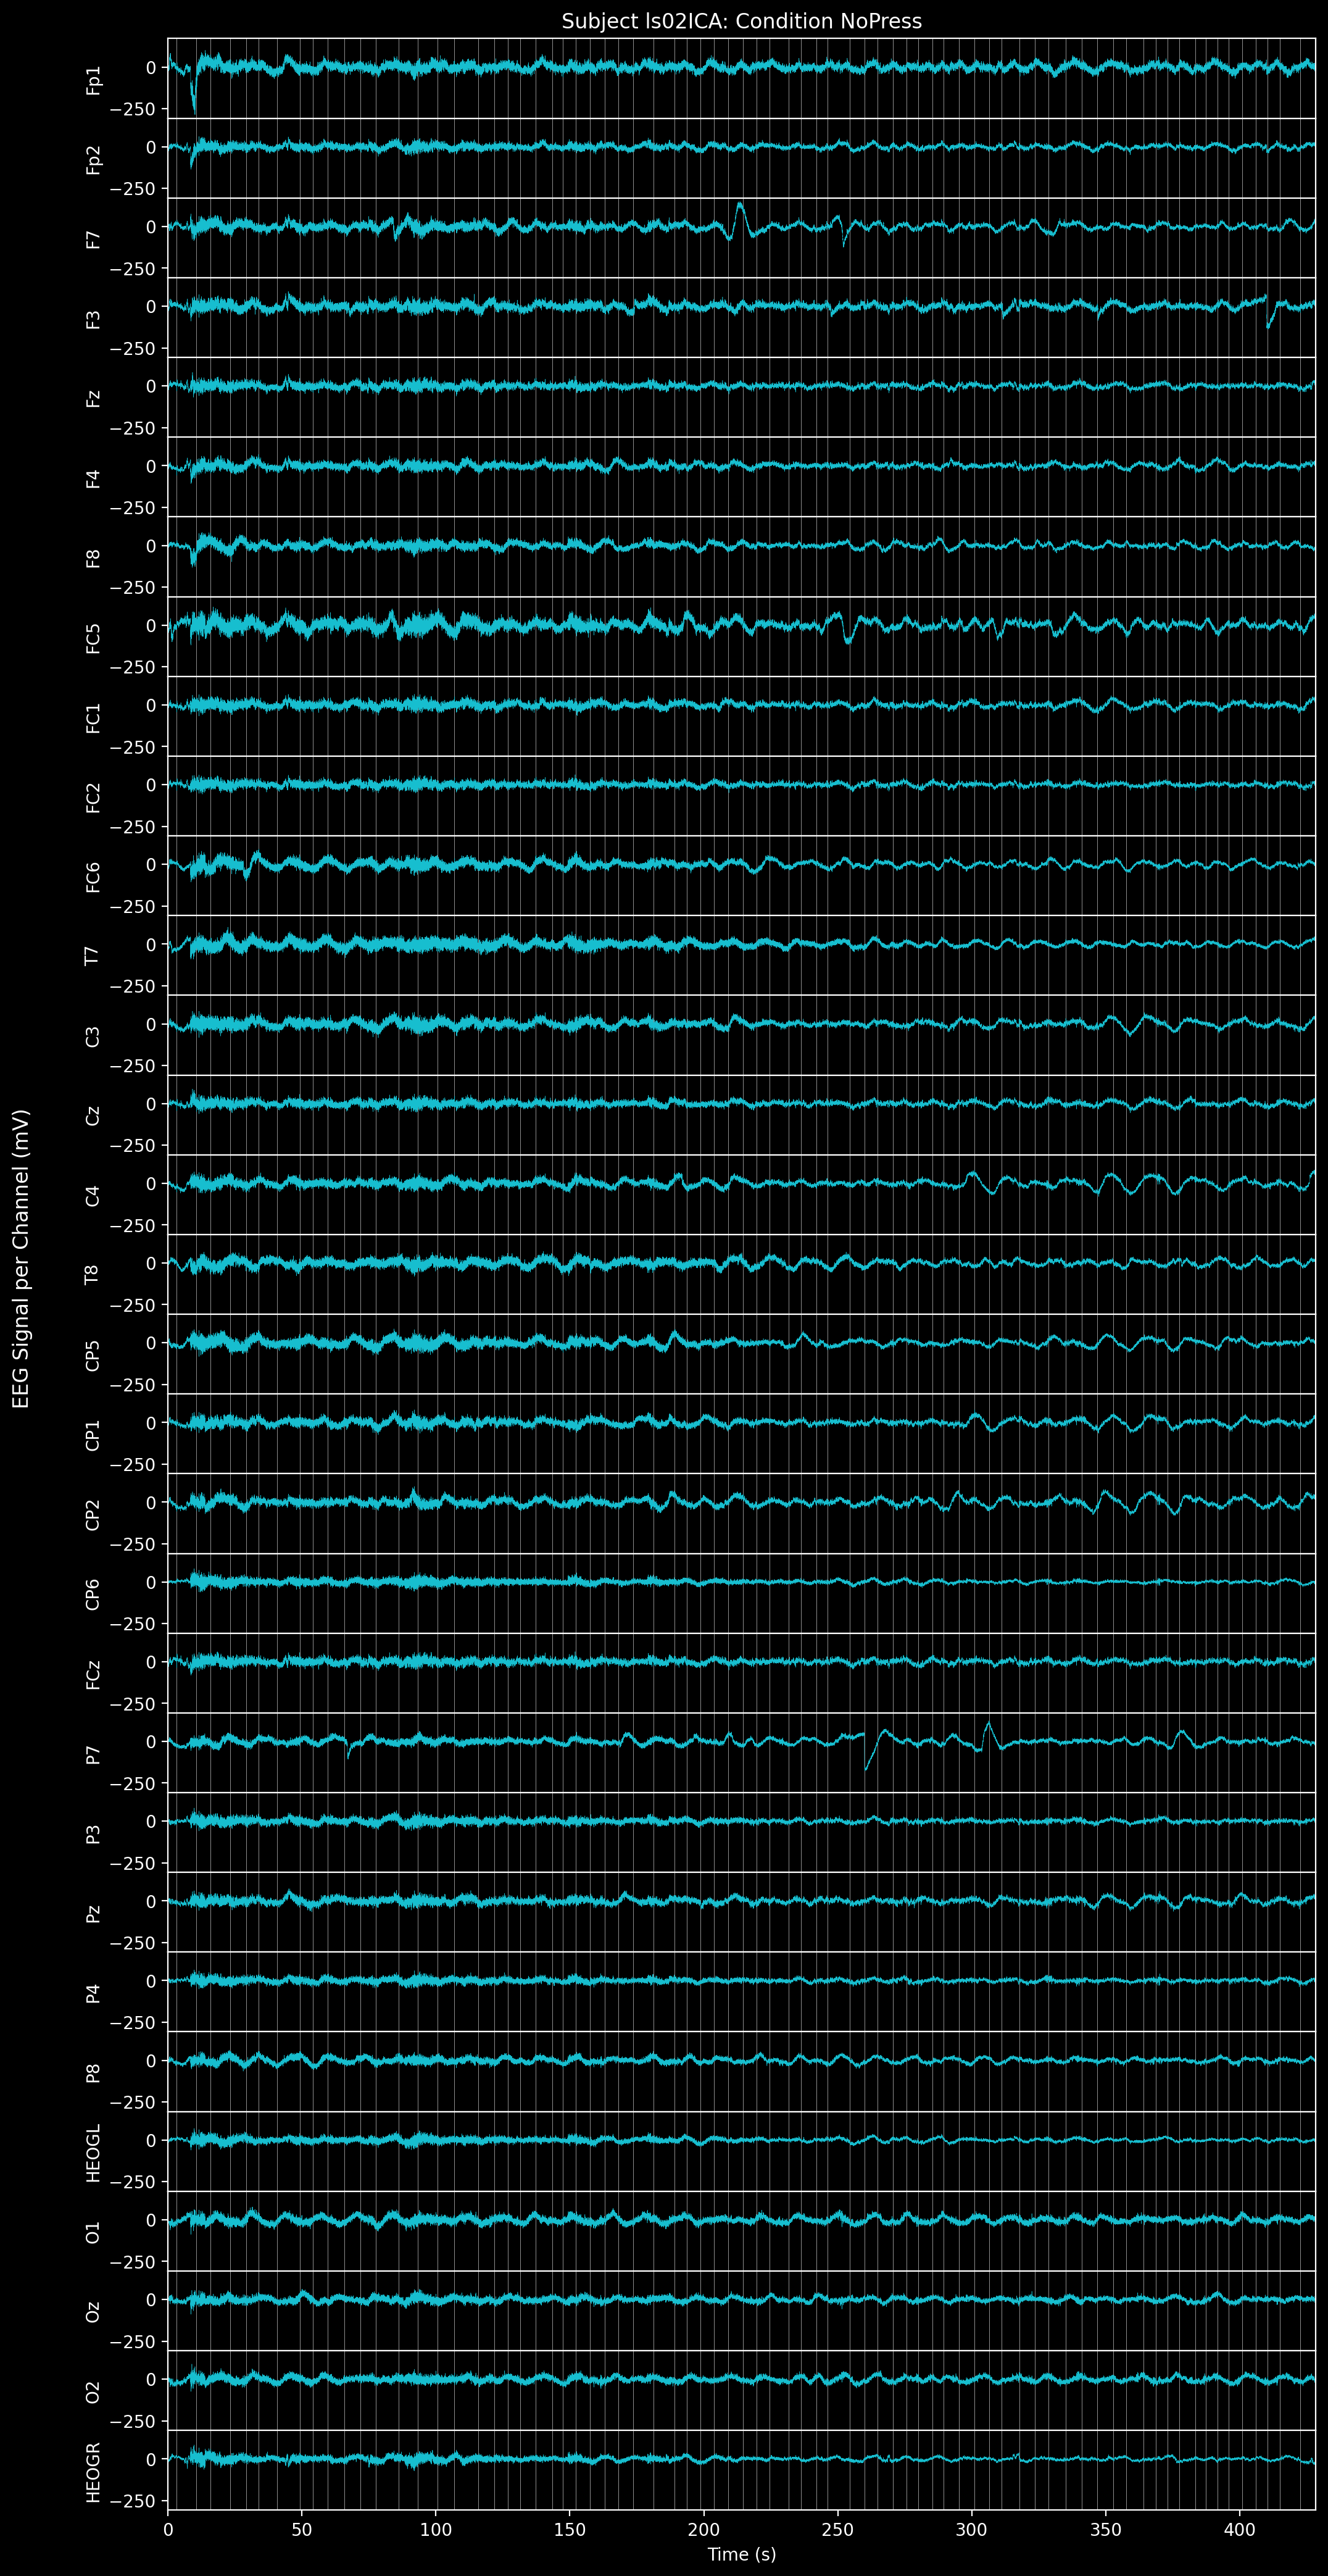

In [12]:
subject = 0
condition = 0

intervals,locations,eeg,sampling_rate,times = get_eeg(data,condition,subject)

fig,axs  = plt.subplots(31,figsize=(12,26),sharey=True)
for channel,ax in enumerate(axs.flatten()):
    ax.set(ylabel=locations[channel],xlim=[times.min()/1e3,times.max()/1e3])
    for soa in intervals:
        for start,end in soa:
            ax.axvline(start/sampling_rate,linewidth=.2,c='w') # beginning of event interval
            # ax.axvline(end/sampling_rate,linewidth=.2,c='grey') # end of event interval
    ax.plot(times/1e3,eeg[channel],linewidth=.2,color='tab:cyan') # in s
    if channel != len(axs)-1:
        ax.set_xticks([])
axs[0].set(title=f'Subject {subjects[subject]}: Condition {conditions[condition]}')
axs[-1].set(xlabel='Time (s)')
fig.supylabel('EEG Signal per Channel (mV)')
# plt.tight_layout(h_pad=0)
plt.subplots_adjust(hspace=0)
plt.show()

### Analyze individual Events

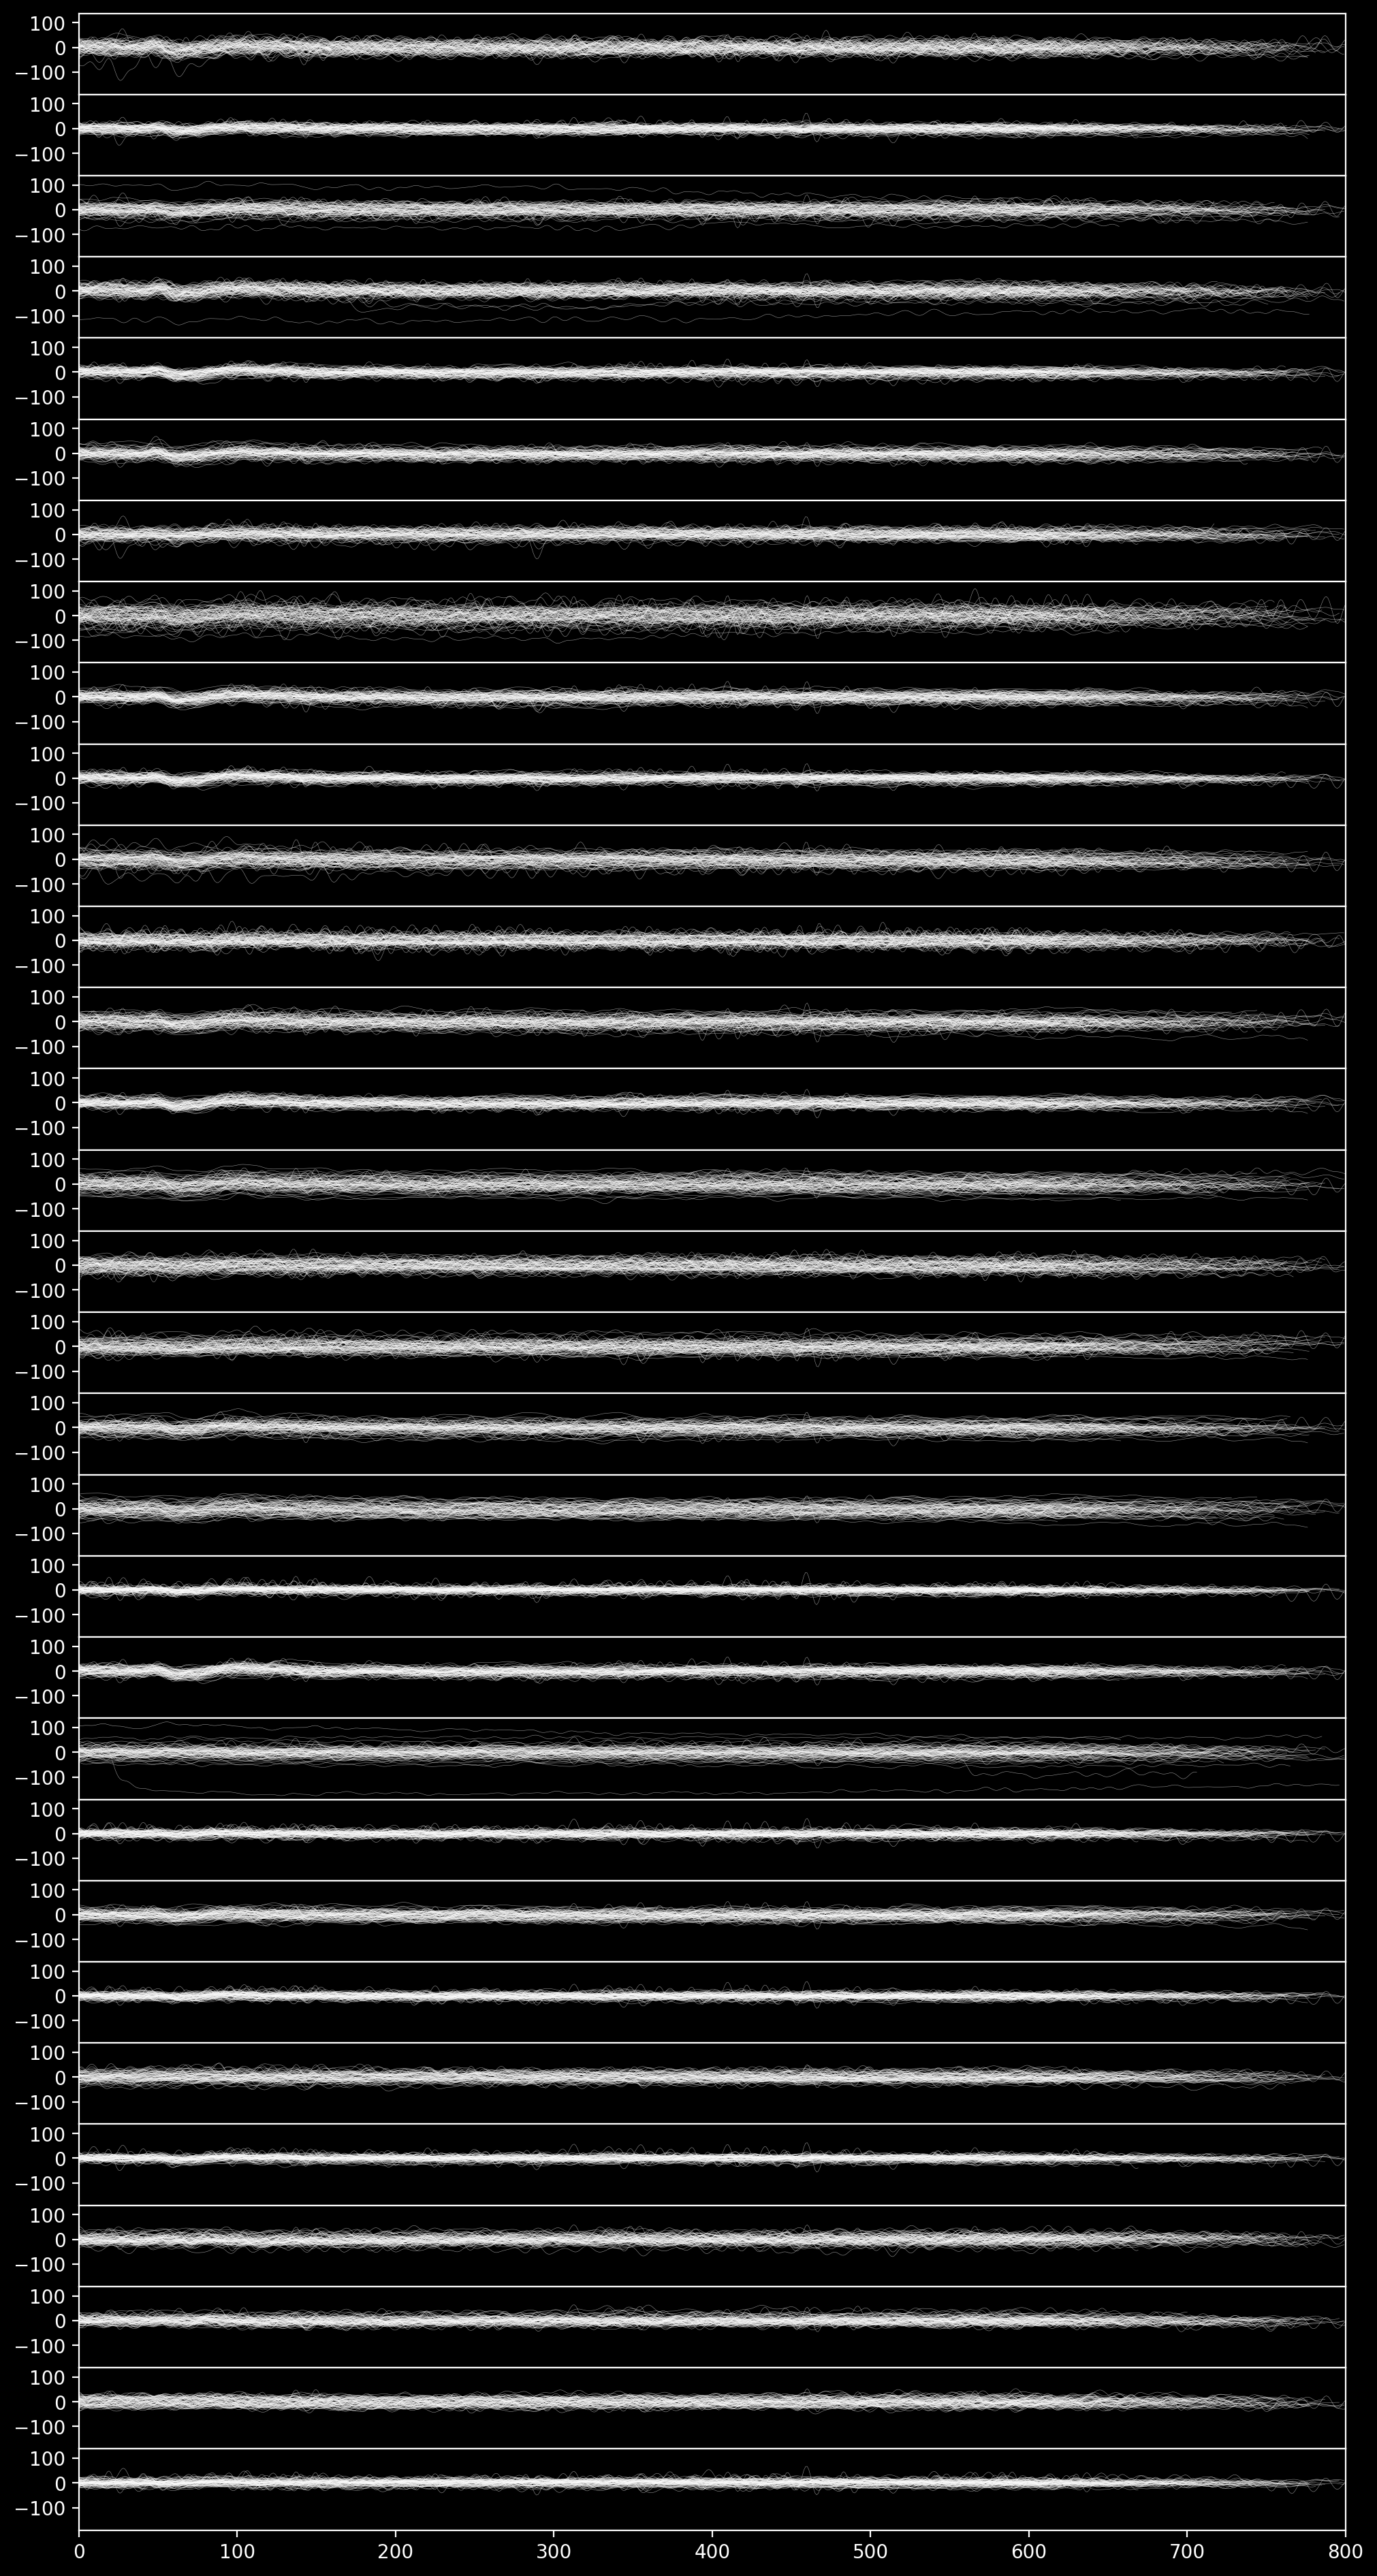

In [13]:
fig,axs = plt.subplots(eeg.shape[0],len(intervals),figsize=(12,24),squeeze=False,sharey=True)
for i,row in enumerate(axs):
    for ax,soa in zip(row,intervals):
        for start,end in soa:
            ax.plot(eeg[i,start:end],linewidth=.2,alpha=.6,color='w')
        ax.set(xlim=(0,800)) # samples
        if i != eeg.shape[0]-1:
            ax.set(xticks=[])
plt.subplots_adjust(hspace=0)
plt.show()

### Signal Processing

In [14]:
def filter_signal(
    signal, SR:float, low:float, high:float, order:int
):
    """Filter raw signal x.

    Parameters
    ----------

    x: (n_channels,n_samples)
        Each row in data is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """

    sos = sp.signal.butter(N=order, Wn=[low, high], btype="bandpass", output="sos", fs=SR)

    return sp.signal.sosfiltfilt(sos, signal)

def get_N1(eeg,intervals,ROI=None) -> float:
    '''Calculate the mean N1 extremum over the specified channels
    
    Params:
    eeg: EEG signal
    intervals: Sample intervals of events
    ROI: channels of interest (optional)
    
    Returns: Relative position of N1 in samples after event'''
    
    if ROI is None:
        ROI = slice(len(eeg)) # consider all channels
    mins = []
    for soa in intervals:
        for start,end in soa:
             # find min in [+50,+100] samples and return index relative to start
            mins.append(np.argmin(eeg[ROI,start+50:start+100],axis=1)+50)
    return np.array(mins).mean()

def get_P2(eeg,intervals,ROI=None) -> float:
    if ROI is None:
        ROI = slice(len(eeg)) # consider all channels
    mins = []
    for soa in intervals:
        for start,end in soa:
             # find min in [+50,+100] samples and return index relative to start
            mins.append(np.argmax(eeg[ROI,start+75:start+125],axis=1)+75)
    return np.array(mins).mean()

Mean N1: 135 ms
Mean P2: 213 ms


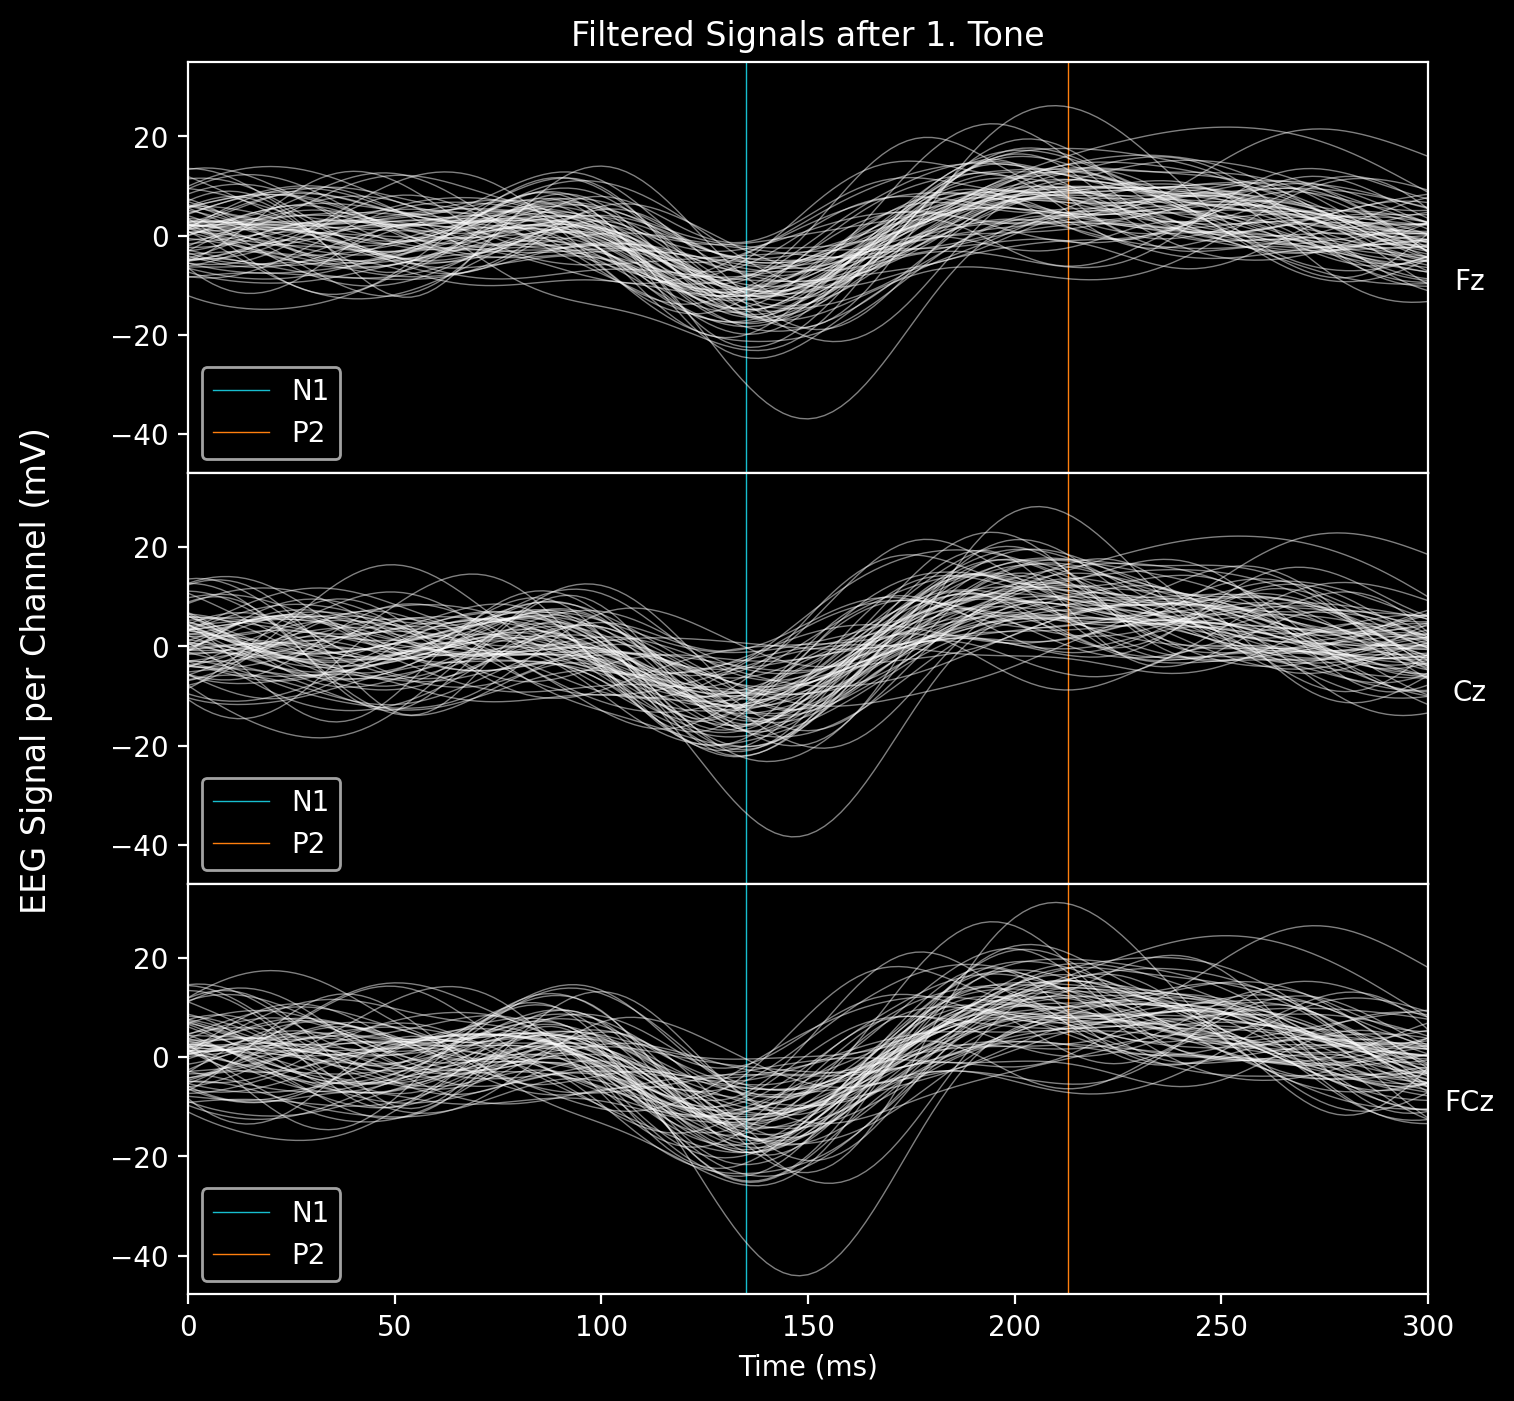

In [15]:
low_pass = 1
high_pass = 14
order = 3

intervals,locations,eeg,sampling_rate,times = get_eeg(data,condition,subject)
eeg_filtered = filter_signal(eeg,sampling_rate,low_pass,high_pass,order)

ROI = np.where([loc in ['Fz','Cz','FCz'] for loc in locations])[0]

n1 = get_N1(eeg_filtered,intervals,ROI)
p2 = get_P2(eeg_filtered,intervals,ROI)

print(f'Mean N1: {n1/sampling_rate*1e3:.0f} ms')
print(f'Mean P2: {p2/sampling_rate*1e3:.0f} ms')

fig,axs = plt.subplots(len(ROI),len(intervals),figsize=(8,8),squeeze=False,sharey=True)
for channel,row in zip(ROI,axs):
    for ax,soa in zip(row,intervals):
        # ax.axvline(100,c='tab:orange',linewidth=.5) # P1
        ax.axvline(n1/sampling_rate*1e3,c='tab:cyan',linewidth=.5) # N1
        ax.axvline(p2/sampling_rate*1e3,c='tab:orange',linewidth=.5) # P2
        ax.legend(['N1','P2'])
        for start,end in soa:
            ax.plot(np.arange(len(eeg_filtered[channel,start:end]))/sampling_rate*1e3, # ms
                    eeg_filtered[channel,start:end],
                    linewidth=.5,alpha=.5,color='w')
        ax.set(xlim=(0,300))
        ax.set_ylabel(locations[channel],rotation=0, labelpad=15)
        ax.yaxis.set_label_position("right")
        if channel != ROI[-1]:
            ax.set(xticks=[])
axs[-1,0].set(xlabel='Time (ms)')
axs[0,0].set(title='Filtered Signals after 1. Tone')
plt.subplots_adjust(hspace=0)
fig.supylabel('EEG Signal per Channel (mV)')
plt.show()

### Subject & Group Mean Analysis

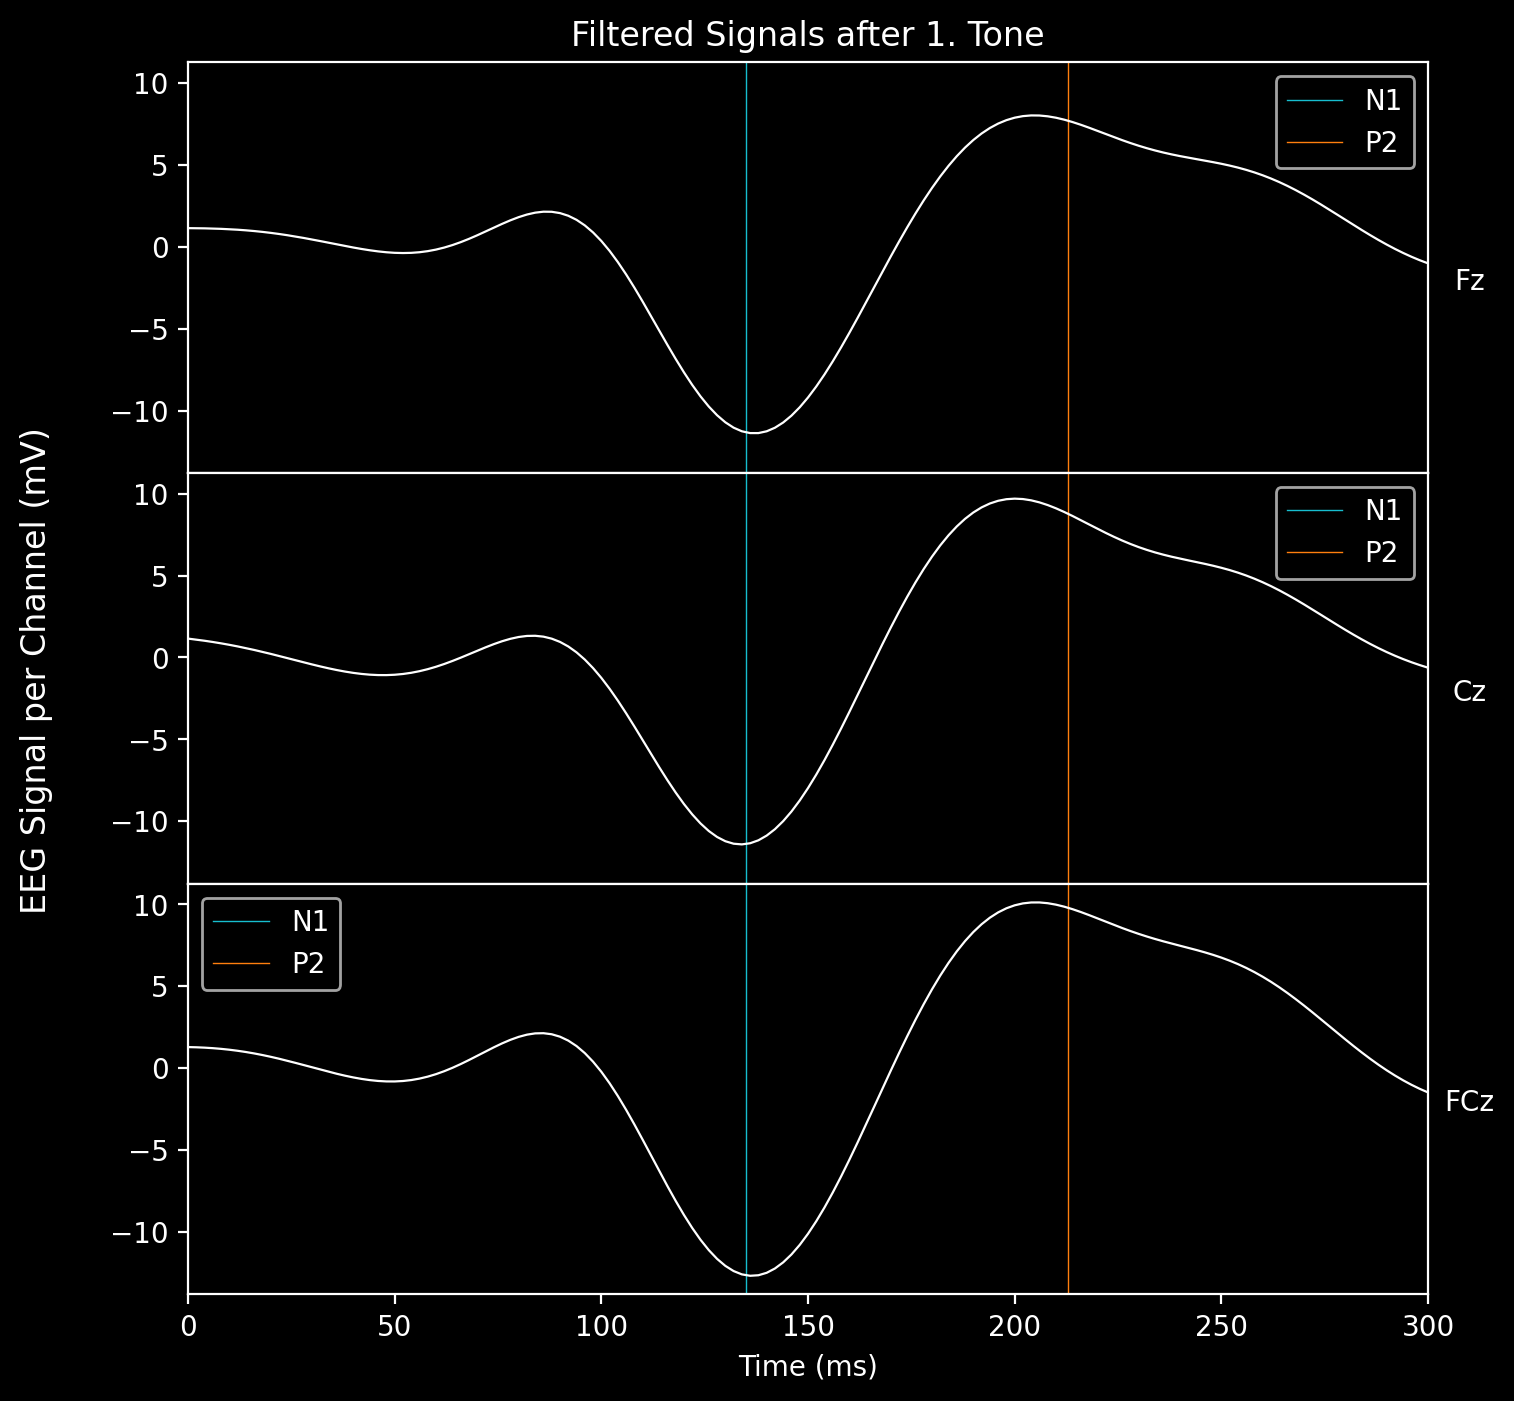

In [21]:
def get_event_mean(signal,intervals,duration,ROI=None):
    if ROI is None:
        ROI = np.arange(len(signal)) # consider all channels
    
    stacked_signal = np.empty((len(intervals),len(ROI),duration))

    for s,soa in enumerate(intervals):
        mean_signal = np.zeros((len(ROI),duration))
        for start,end in soa:
            mean_signal += signal[ROI,start:start+duration]
        stacked_signal[s] = mean_signal / len(soa)
        
    return stacked_signal

means = get_event_mean(eeg_filtered,intervals,200)

fig,axs = plt.subplots(len(ROI),len(intervals),figsize=(8,8),squeeze=False,sharey=True)
for channel,row in zip(ROI,axs):
    for soa,ax in enumerate(row):
        # ax.axvline(100,c='tab:orange',linewidth=.5) # P1
        ax.axvline(n1/sampling_rate*1e3,c='tab:cyan',linewidth=.5) # N1
        ax.axvline(p2/sampling_rate*1e3,c='tab:orange',linewidth=.5) # P2
        ax.legend(['N1','P2'])
        #ax.fill_between(np.arange(len(means[channel,soa]))/sampling_rate*1e3,
        #                means[channel,soa]+stds[channel,soa],
        #                means[channel,soa]-stds[channel,soa],
        #                alpha=.1,color='w',edgecolor='none')
        ax.plot(np.arange(len(means[soa,channel]))/sampling_rate*1e3, # ms
                means[soa,channel],
                linewidth=.8,color='w')
        ax.set(xlim=(0,300))
        ax.set_ylabel(locations[channel],rotation=0, labelpad=15)
        ax.yaxis.set_label_position("right")
        if channel != ROI[-1]:
            ax.set(xticks=[])
axs[-1,0].set(xlabel='Time (ms)')
axs[0,0].set(title='Filtered Signals after 1. Tone')
plt.subplots_adjust(hspace=0)
fig.supylabel('EEG Signal per Channel (mV)')
plt.show()

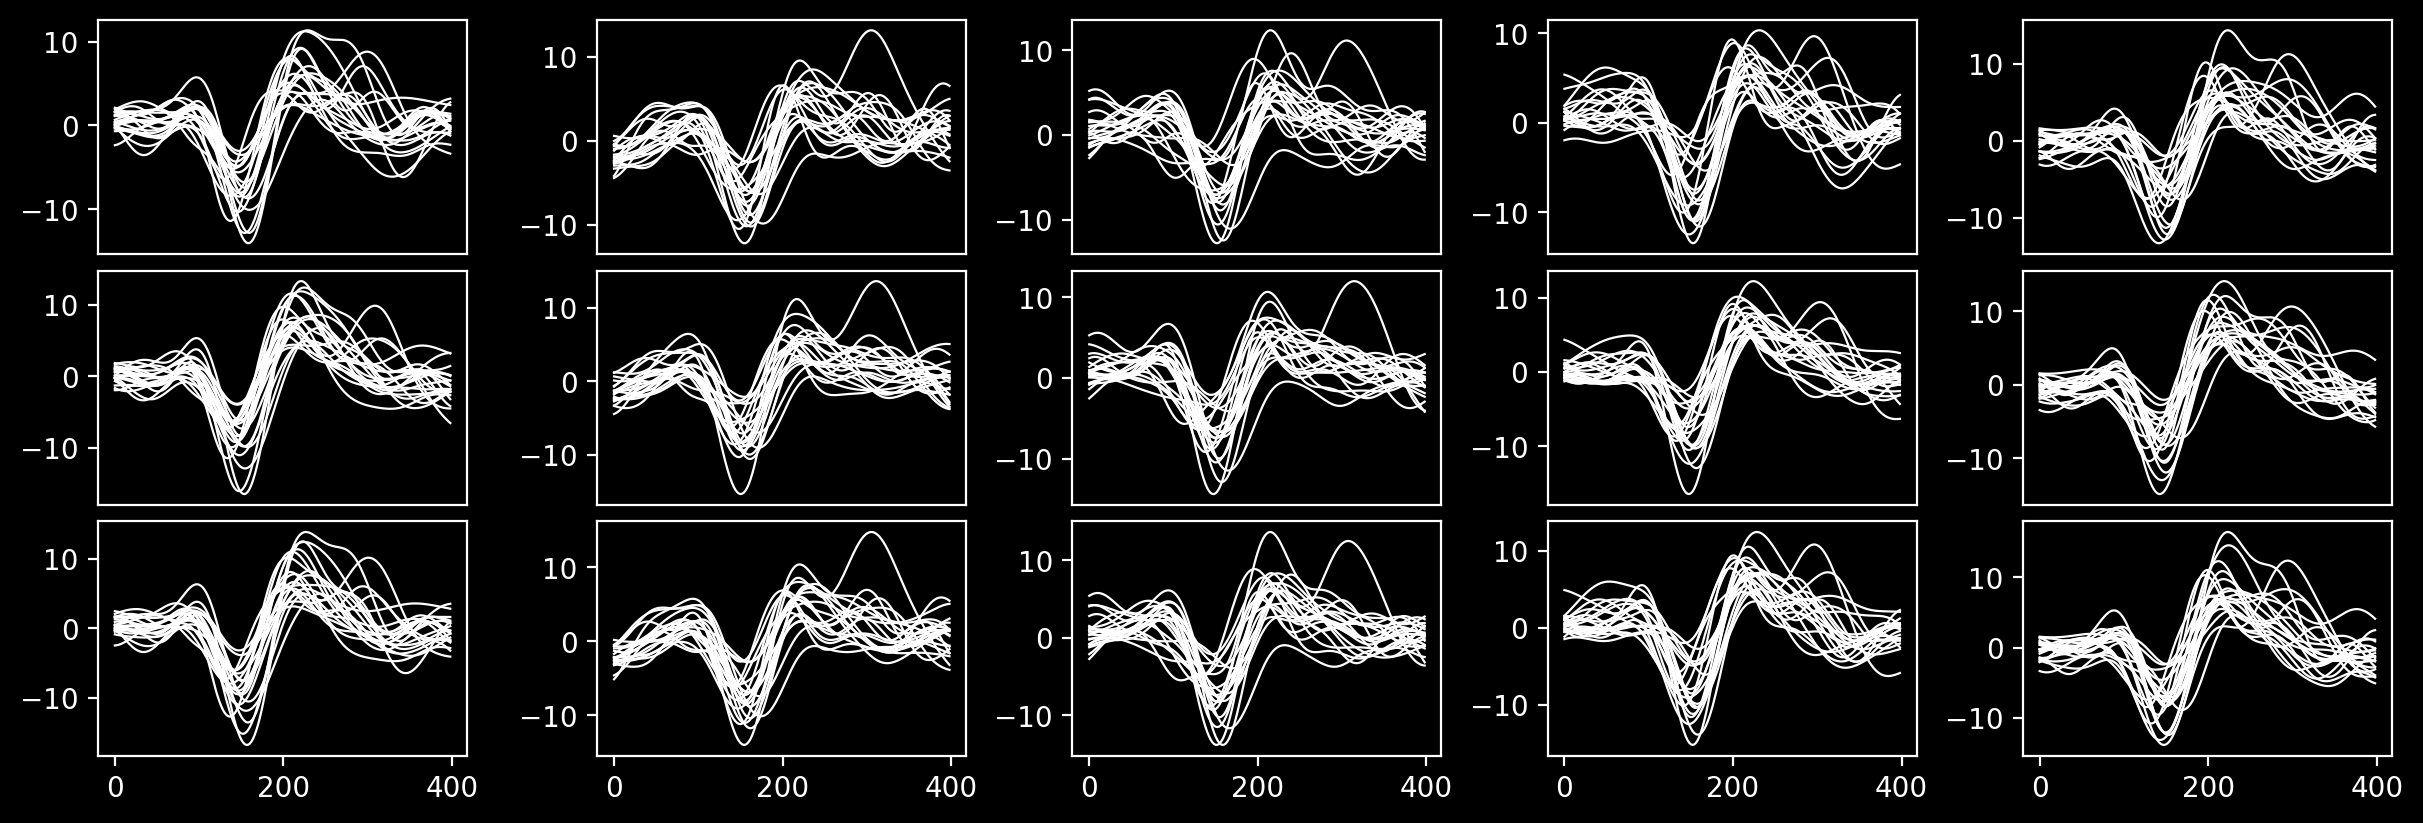

In [45]:
erp_duration = 200 # samples

fig = plt.figure(figsize=(12,4),layout='constrained')
subfigs = fig.subfigures(1,2,width_ratios=[1,4])
        
num_soa = {'NoPress':1,'Sound':4}

for i,condition in enumerate(conditions):
    axs = subfigs[i].subplots(len(ROI),num_soa[condition],squeeze=False)
    for channel,row in enumerate(axs):
        for soa,ax in enumerate(row):
            for subject in subjects:
                intervals,locations,eeg,sampling_rate,times = get_eeg(data,condition,subject)
                eeg_f = filter_signal(eeg,sampling_rate,low_pass,high_pass,order)
                means = get_event_mean(eeg_f,intervals,erp_duration,ROI) # (soa,channel,duration)
                # ax.axvline(100,c='tab:orange',linewidth=.5) # P1
                #ax.axvline(n1/sampling_rate*1e3,c='tab:cyan',linewidth=.5) # N1
                #ax.axvline(p2/sampling_rate*1e3,c='tab:orange',linewidth=.5) # P2
                #ax.legend(['N1','P2'])
                #ax.fill_between(np.arange(len(means[channel,soa]))/sampling_rate*1e3,
                #                means[channel,soa]+stds[channel,soa],
                #                means[channel,soa]-stds[channel,soa],
                #                alpha=.1,color='w',edgecolor='none')
                ax.plot(np.arange(len(means[soa,channel]))/sampling_rate*1e3, # ms
                        means[soa,channel],
                        linewidth=.8,color='w')
                #ax.set(xlim=(0,400))
                #ax.set_ylabel(locations[channel],rotation=0, labelpad=15)
                #ax.yaxis.set_label_position("right")
                if channel != len(ROI)-1:
                    ax.set(xticks=[])
        #axs[-1,0].set(xlabel='Time (ms)')
        #axs[0,0].set(title='Filtered Signals after 1. Tone')
        #fig.supylabel('EEG Signal per Channel (mV)')


# Baseline correction:
For each subject, condition, channel and trial subract baseline activity (200ms) before event (press? = S 10)

# Motor correction:
From NoSound condition extract data window from each channel with respect to SOA (pre+SOA:post+SOA)